# Mastering Continuous Control: Comparing A2C, SAC, and TD3 in OpenAI Gym

## Introduction

In this notebook I will demonstrate using three RL methods on two different OpenAI environments with continuous action and observation spaces. I provide the tools to train a model and evaluate a method in terms of performance, sample efficiency, method specific criteria, and robustness. This notebook will feature a single algorithm on both environments however the github repo contains all the necessary code to run the two other algorithms. 

## Set up conda env and Install Dependencies

Set up and activate conda environment 
```
conda env create -f environment.yml

conda activate py37
```

It is import to note that the algorithms are imported from Stable Baselines3

## Import Packages

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import argparse
import yaml
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from stable_baselines3 import A2C, SAC, TD3
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.common.utils import get_schedule_fn
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import CallbackList, CheckpointCallback, EvalCallback, StopTrainingOnRewardThreshold

/home/sophie/miniconda3/envs/py37/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Custom implementation

My custom implementation includes training of three methods on two different environments, logging, custom callbacks, and evaluation with tensorboard

### Custom Callback class
Sample efficiency callback 

In [2]:
class SampleEfficiencyCallback(BaseCallback):
    """
    Callback to track rewards and total environment steps during training.
    Logs sample efficiency for later analysis.
    """
    def __init__(self, log_dir, verbose=0):
        super(SampleEfficiencyCallback, self).__init__(verbose)
        self.rewards = []
        self.timesteps = []
        self.log_dir = log_dir

    def _on_step(self) -> bool:
        # Log the episode reward and total timesteps
        if "episode" in self.locals["infos"][0]:
            self.rewards.append(self.locals["infos"][0]["episode"]["r"])
            self.timesteps.append(self.num_timesteps)
        return True

    def save_results(self):
        # Save results for plotting
        np.savetxt(os.path.join(self.log_dir, "sample_efficiency.csv"),
                   np.column_stack((self.timesteps, self.rewards)),
                   header="timesteps,rewards", delimiter=",", comments="")

### Set deterministic seed

In [5]:
def set_seed(seed):
    """
    Set random seeds for reproducibility.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

### Function to load hyperparameters from RL Baselines3 Zoo

In [3]:
def load_hyperparameters(algo_name, env_name):
    """
    Load hyperparameters from RL Baselines3 Zoo configuration files.
    """
    algo_name = algo_name.lower()
    config_path = f"../hyperparameters/{algo_name}.yml"
    with open(config_path, "r") as file:
        hyperparams = yaml.safe_load(file)

    # Get the specific hyperparameters for the environment
    if env_name in hyperparams:
        hyperparams = hyperparams[env_name]
        return hyperparams

### Plotting Function for Sample Efficiency

In [4]:
def plot_sample_efficiency(log_dir):
    """
    Plot sample efficiency: Rewards vs. Environment Steps.
    """
    data = np.loadtxt(os.path.join(log_dir, "sample_efficiency.csv"), delimiter=',', skiprows=1)
    timesteps, rewards = data[:, 0], data[:, 1]

    plt.figure(figsize=(10, 5))
    plt.plot(timesteps, rewards, label="Sample Efficiency")
    plt.xlabel("Environment Steps")
    plt.ylabel("Episodic Rewards")
    plt.title("Sample Efficiency: Rewards vs Environment Steps")
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(log_dir, "sample_efficiency.png"))
    plt.show()

### Saving the trained model

In [6]:
def save_model(model, method, env_name, normalize, vec_env, log_dir):
    # Save the model
    model.save(f"../models/{method.lower()}_{env_name}")
    if normalize:
        vec_env.save(f"../models/{method.lower()}_{env_name}_vec_normalize.pkl")
    print("Training complete. Model saved.")
    
    # Plot sample efficiency
    print("Plotting sample efficiency...")
    plot_sample_efficiency(log_dir)

### Training
This custom training function includes a vectorized environment (Pendulum or BipedalWalker), hyperparameter integration, method selection based on user input, training with model.learn(...), logging different metrics during training. 

In [7]:
def train(method, env_name, hyperparams, tensor_board_dir, log_dir):
    # For make_vec_env
    n_envs = hyperparams.pop("n_envs", 1)
    normalize = hyperparams.pop("normalize", False)
    
    vec_env = make_vec_env(env_name, n_envs=n_envs)
    if normalize:
        vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=True, clip_obs=10.0)
    
    # Create a callback to log sample efficiency
    sample_callback = SampleEfficiencyCallback(log_dir=log_dir)
    
    if env_name == "BipedalWalker-v3":
        # Stop training when the model reaches the reward threshold
        callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=300, verbose=1)
        eval_callback = EvalCallback(vec_env, callback_on_new_best=callback_on_best, verbose=1)
    
        callback = CallbackList([sample_callback, eval_callback])
    elif env_name == "Pendulum-v1":
        callback = sample_callback
        
    
    # Not in all hyperparameter files
    policy_kwargs = hyperparams.pop("policy_kwargs", None)
    if isinstance(policy_kwargs, str):
        policy_kwargs = eval(policy_kwargs)
    
    learning_rate = hyperparams.pop("learning_rate", None)
    
    # Convert learning rate to a callable function
    if isinstance(learning_rate, str):
        if learning_rate.startswith("lin_"):
            # Extract the numerical part after "lin_"
            lr_value = float(learning_rate.split("_")[1])
            learning_rate = get_schedule_fn(lr_value)
        else:
            raise ValueError(f"Unsupported learning rate format: {learning_rate}")
    
    policy = hyperparams.pop("policy", None)
    
    # For model.learn
    n_timesteps = hyperparams.pop("n_timesteps", None)
    
    # Select the model
    if method == "a2c":
        model = A2C(policy=policy, env=vec_env, verbose=1, tensorboard_log=tensor_board_dir, policy_kwargs=policy_kwargs, learning_rate=learning_rate, **hyperparams)
    elif method == "sac":
        model = SAC(policy=policy, env=vec_env, verbose=1, tensorboard_log=tensor_board_dir, policy_kwargs=policy_kwargs, learning_rate=learning_rate, **hyperparams)
    elif method == "td3":
        noise_type = hyperparams.pop("noise_type", "normal")
        
        if noise_type == "normal":
            n_actions = vec_env.action_space.shape[-1]
            noise_std = hyperparams.pop("noise_std", None)
            hyperparams["action_noise"] = NormalActionNoise(mean=np.zeros(n_actions), sigma=noise_std * np.ones(n_actions))
            
        elif noise_type == "ornstein_uhlenbeck":
            print("Warning: Ornstein-Uhlenbeck noise is not implemented.")
            
        model = TD3(policy=policy, env=vec_env, verbose=1, tensorboard_log=tensor_board_dir, policy_kwargs=policy_kwargs, learning_rate=learning_rate, **hyperparams)
        
    else:
        raise ValueError(f"Unsupported method: {method}, please choose from 'A2C', 'SAC', or 'TD3'.")

    # Train the model
    print(f"Training {method} on {env_name}...")
    if n_timesteps is not None:
        model.learn(n_timesteps, callback=callback)
    else:
        print("Error: n_timesteps not specified.")
    
    # Save the results
    sample_callback.save_results()
    
    return model, vec_env, normalize

## Main 
This is where hyperparameters are loaded, method is trained on env, and model is evaluated

Here you can set the algorithm, env, and seed for training and evaluation

In [15]:
# Parse command-line arguments
parser = argparse.ArgumentParser(description="Train an RL model on a specified environment.")
parser.add_argument("--env", type=str, required=True, help="Name of the OpenAI Gym environment. (Please use Pendulum or BipedalWalker)")
parser.add_argument("--method", type=str, required=True, help="RL method to use (A2C, SAC, or TD3).")
parser.add_argument("--seed", type=int, default=0, help="Random seed for reproducibility.")
# Set Algorithm, Environment, and Seed here
args = parser.parse_args("--env Pendulum-v1 --method A2C --seed 1".split())


=== Training with seed: 1 ===
Using cpu device
Training a2c on Pendulum-v1...
Logging to ./tensorboard/a2c_Pendulum-v1_seed1/A2C_1
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 200       |
|    ep_rew_mean        | -1.6e+03  |
| time/                 |           |
|    fps                | 8105      |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 6400      |
| train/                |           |
|    entropy_loss       | -0.448    |
|    explained_variance | 0.936     |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -0.000321 |
|    std                | 0.136     |
|    value_loss         | 1.14e-05  |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 200      |
|    ep_rew_mean        | -1.5e+03 |
| time/                 |          |


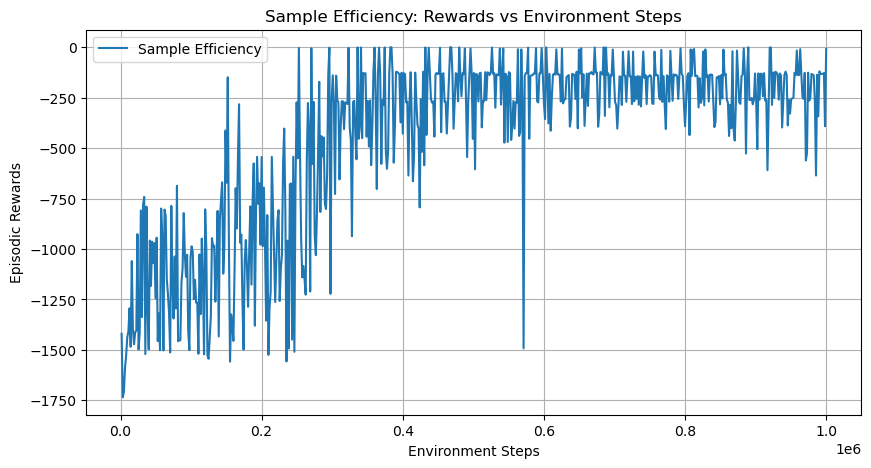

Evaluating model...
Seed 1: mean_reward:-231.49 +/- 113.72


In [16]:
# Set the seed
seed = args.seed
print(f"=== Training with seed: {seed} ===")
set_seed(seed)

# Logging directories
env_name = args.env
method = args.method.lower()
tensor_board_dir = f"./tensorboard/{method}_{env_name}_seed{seed}/"
os.makedirs(tensor_board_dir, exist_ok=True)
log_dir = f"./logs/{method}_{env_name}_seed{seed}"
os.makedirs(log_dir, exist_ok=True)

# Load hyperparameters
hyperparams = load_hyperparameters(method, env_name)

# Train and save the model
model, vec_env, normalize = train(method, env_name, hyperparams, tensor_board_dir, log_dir)
save_model(model, method, env_name, normalize, vec_env, log_dir)

# Evaluate the model
print("Evaluating model...")
mean_reward, std_reward = evaluate_policy(model, vec_env, n_eval_episodes=100)
print(f"Seed {seed}: mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

You can deploy tensorboard in the terminal to look at algorithm specific metrics

```
tensorboard --logdir ../notebooks/tensorboard/a2c_Pendulum-v1_seed1/
```

Rollout Episode Reward Mean 

![alt text](rollout_ep_rew_mean.svg)

Other Tensorboard training time visuals

![alt text](tensorboard_visulization.png)

Comprehensive results and plots are presented in the paper